In [63]:
using Revise
using TransportBasedInference
using HierarchicalDA
using LinearAlgebra
using OrdinaryDiffEq
using Trixi
using FFTW
using DifferentialEquations
using Distributions
using Statistics
using SparseArrays
using LinearMaps
using IterativeSolvers
using Preconditioners

In [2]:
using CairoMakie
using LaTeXStrings
# using Plots

In [3]:
polydeg = 3
Ncells = 100

Nx = (polydeg+1)*Ncells
Δ = 20
Ny = ceil(Int64, Nx/Δ)

# Define Trixi system for inviscid Burgers equation
sys_burgers = setup_burgers(polydeg, Ncells);

xgrid = vec(sys_burgers.mesh.md.xq);

Define polynomial annihilator operator

In [4]:
order_PA = 2

Ns = Nx - 2*ceil(Int64, order_PA/2)

PA = PolyAnnil(xgrid, order_PA; istruncated = true)

@assert size(PA.P) == (Ns, Nx)

S = LinearMaps.FunctionMap{Float64,true}((s,x)->mul!(s, PA.P, x), (x,s)->mul!(x, PA.P', s),
Ns, Nx; issymmetric=false, isposdef=false)

xs = xgrid[ceil(Int64, order_PA/2)+1:end-ceil(Int64, order_PA/2)]

398-element Vector{Float64}:
 -0.9933998104358487
 -0.9866001895641519
 -0.9813886368840595
 -0.9786113631159403
 -0.9733998104358488
 -0.9666001895641518
 -0.9613886368840595
 -0.9586113631159403
 -0.9533998104358486
 -0.9466001895641517
 -0.9413886368840595
 -0.9386113631159403
 -0.9333998104358486
  ⋮
  0.9386113631159406
  0.9413886368840593
  0.9466001895641516
  0.9533998104358488
  0.9586113631159405
  0.9613886368840594
  0.9666001895641515
  0.973399810435849
  0.9786113631159405
  0.9813886368840595
  0.9866001895641516
  0.9933998104358489

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.01
Δtobs = 0.01

0.01

Define the time span of interest

In [6]:
t0 = 0.0
Tf = 100
Tspin = 1000
tf = t0 + Tf*Δtobs

1.0

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 400
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


In [8]:
σx_true = 0.001#Δtobs*1.0
σx = 0.01#copy(σx_true)
@show σx


σy = 0.2

ϵx_true = AdditiveInflation(Nx, zeros(Nx), σx_true)
ϵx = AdditiveInflation(Nx, zeros(Nx), σx)

ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

σx = 0.01


AdditiveInflation(20, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.04000000000000001 0.0 … 0.0 0.0; 0.0 0.04000000000000001 … 0.0 0.0; … ; 0.0 0.0 … 0.04000000000000001 0.0; 0.0 0.0 … 0.0 0.04000000000000001], [0.2 0.0 … 0.0 0.0; 0.0 0.2 … 0.0 0.0; … ; 0.0 0.0 … 0.2 0.0; 0.0 0.0 … 0.0 0.2])

Setup system for inviscid Burgers equation

In [9]:
h(x, t) = x[1:Δ:end]
H = LinearMap(sparse(Matrix(1.0*I, Nx, Nx)[1:Δ:end,:]))
F = StateSpace(x->x, h)

StateSpace(var"#5#6"(), TransportBasedInference.var"#27#28"(), h)

Define ObsConstraintSystem

In [10]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx_true, ϵy, π0, 0, 0, 0, F);

In [11]:
# Define function class for the initial condition
αk = 0.7
f0 = SmoothPeriodic(xgrid, αk; L = 2.0)

SmoothPeriodic(400, 1, 2.0, 0.7, ComplexF64[-0.13843584710538373 + 0.3161719346933383im, 0.15789391158306867 - 0.4866470361542134im, 0.1956932702028583 + 0.5897517794057533im, 0.40249904542063936 - 0.4787950368248939im, 0.261107225818374 - 0.15367219057269138im, 0.12366797692352333 - 0.18489337003912365im, 0.16523727589566176 + 0.05740774283925987im, 0.11176438938476439 - 0.018872293293108355im, 0.16052125331321843 - 0.19185185856855602im, 0.12474687823209216 - 0.014784506717467052im  …  -2.7309949277604524e-15 + 1.0977645313625594e-14im, 1.7893656493525315e-15 - 3.280923447098643e-15im, 4.733825096903283e-16 - 9.017416580025304e-15im, -4.863110708327764e-15 + 6.619776363520636e-16im, -8.399580187716968e-16 - 8.802557465999088e-15im, -9.364420318999262e-15 - 2.868516866468785e-15im, 7.725100076258519e-15 - 3.052754947991258e-15im, 5.0827159461290925e-15 - 4.0772541054953705e-15im, 4.278446642922586e-15 + 1.5717370067094785e-15im, -4.115021121346785e-15 + 4.070682740244128e-15im])

In [12]:
# x0 = vec(1/4 .+ 0.5*sin.(2*π*sys_burgers.mesh.md.xq));
x0 = f0.(xgrid);

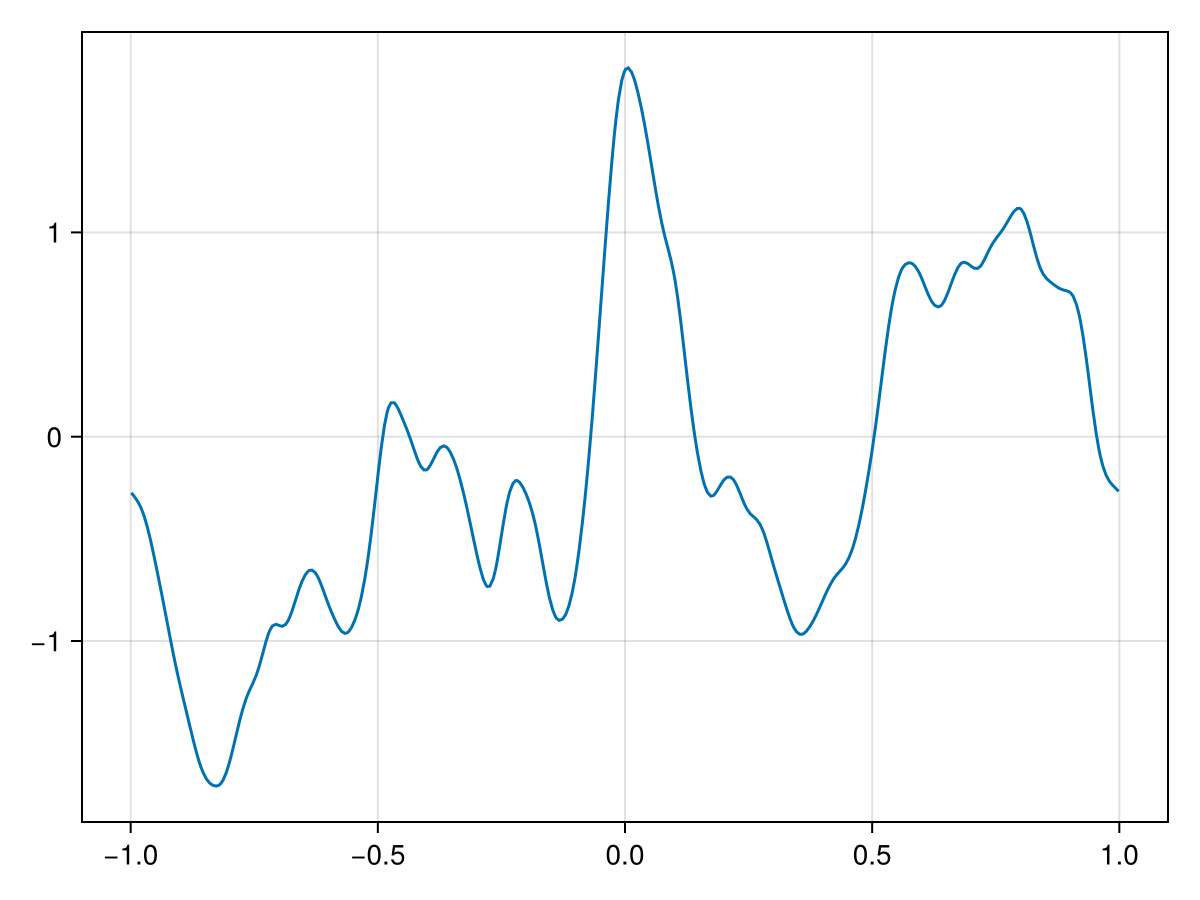

In [13]:
lines(xgrid, x0)

In [14]:
@time data = generate_data_trixi(model, x0, Tf, sys_burgers)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


 15.507931 seconds (38.30 M allocations: 2.316 GiB, 2.80% gc time, 99.15% compilation time)


SyntheticData([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1  …  0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0], 0.01, [-0.27481668823837374, -0.29008885563382314, -0.3137490279674571, -0.336572673610395, -0.3511495273861238, -0.38423253292281456, -0.4396570435979841, -0.49042058805447847, -0.519678048980782, -0.5775340482880315  …  0.012526590943802972, -0.06044651847299372, -0.09308867843514324, -0.14303409575470108, -0.18895525630720342, -0.21281965470535735, -0.22265963243719541, -0.2376711267596856, -0.2543443966017251, -0.26737451171853505], [-0.28321210235239735 -0.2932876089433705 … -0.49901664063218454 -0.48921587700405417; -0.29887611203757297 -0.3085413582279965 … -0.4880266607249062 -0.481039248572568; … ; -0.2588903832096568 -0.26638490881208005 … -0.5012609320641422 -0.503159073541339; -0.2736712561551048 -0.2821733883861881 … -0.5025142701596812 -0.4958084711104618], [-0.18442206698295138 0.007404208814853097 … -0.47441

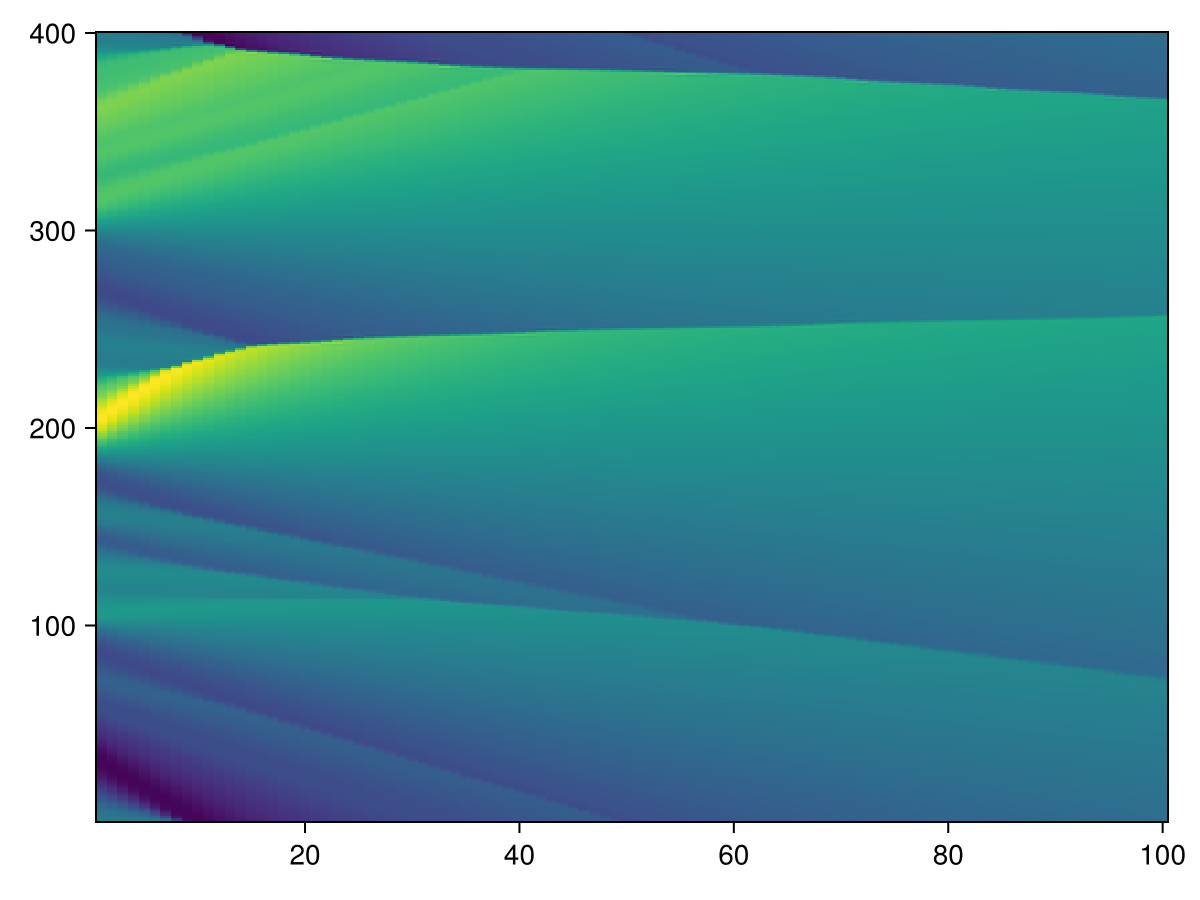

In [15]:
heatmap(data.xt[:, 1:end]')

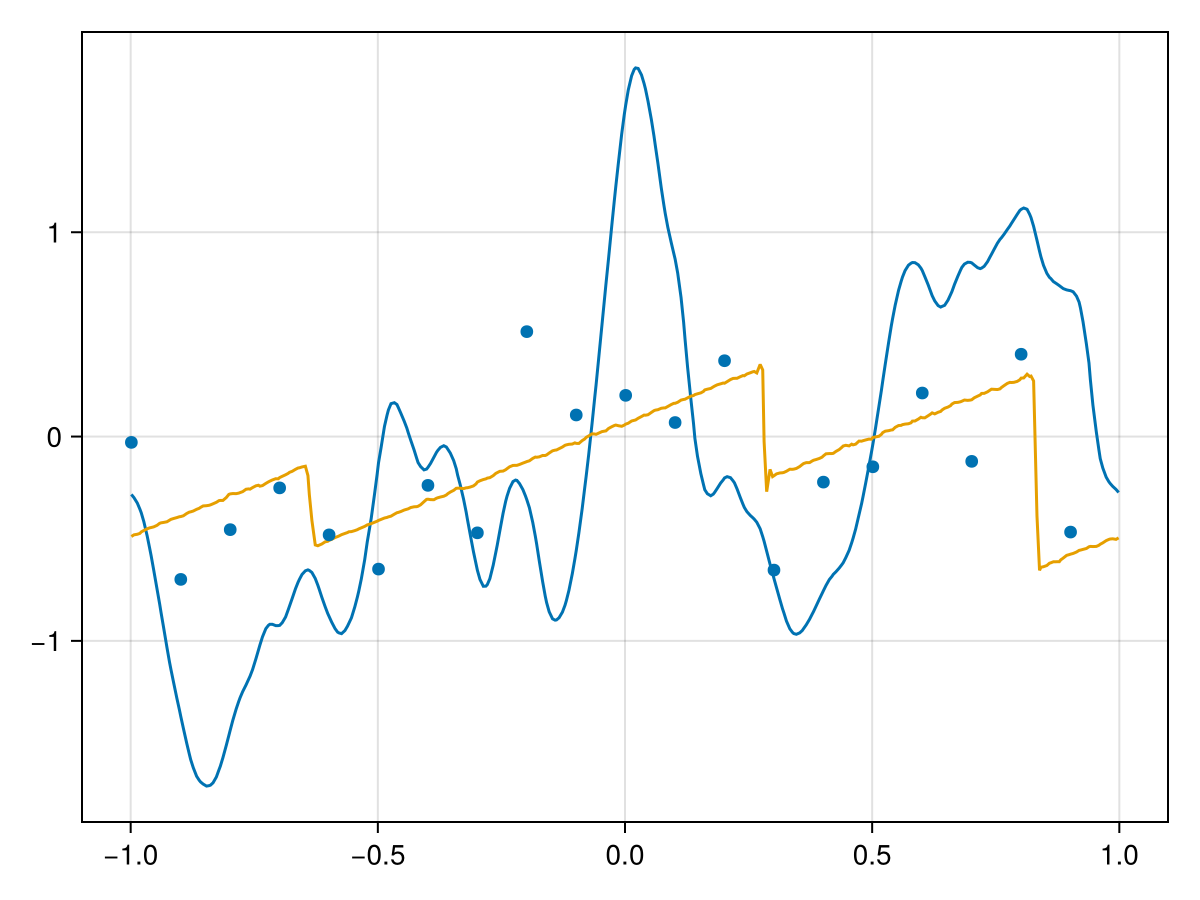

In [16]:
fig = Figure()
ax = Axis(fig[1,1])

lines!(ax, xgrid, data.xt[:,1])
lines!(ax, xgrid, data.xt[:,100])
scatter!(ax, xgrid[1:Δ:end], data.yt[:,100])

fig

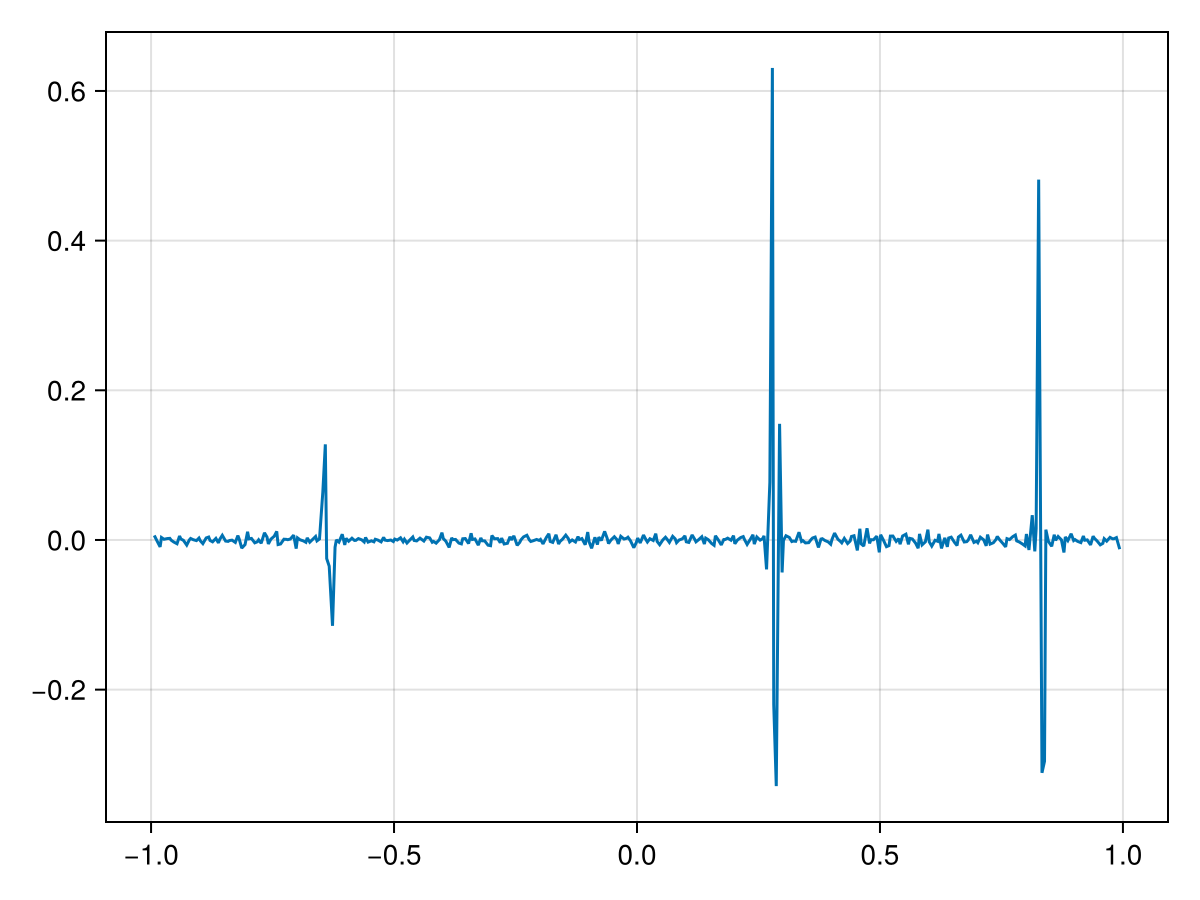

In [17]:
fig = Figure()
ax = Axis(fig[1,1])

# lines!(ax, xgrid, data.xt[:,1])
lines!(ax, xs, PA*data.xt[:,100])

fig

Create initial ensemble

In [18]:
Ne = 100
X0 = zeros(model.Ny + model.Nx, Ne)

for i=1:Ne
    regenerate!(f0)
    X0[Ny+1:Ny+Nx,i] = f0.(xgrid)#initial_condition(αk, Δx, Nx)
end

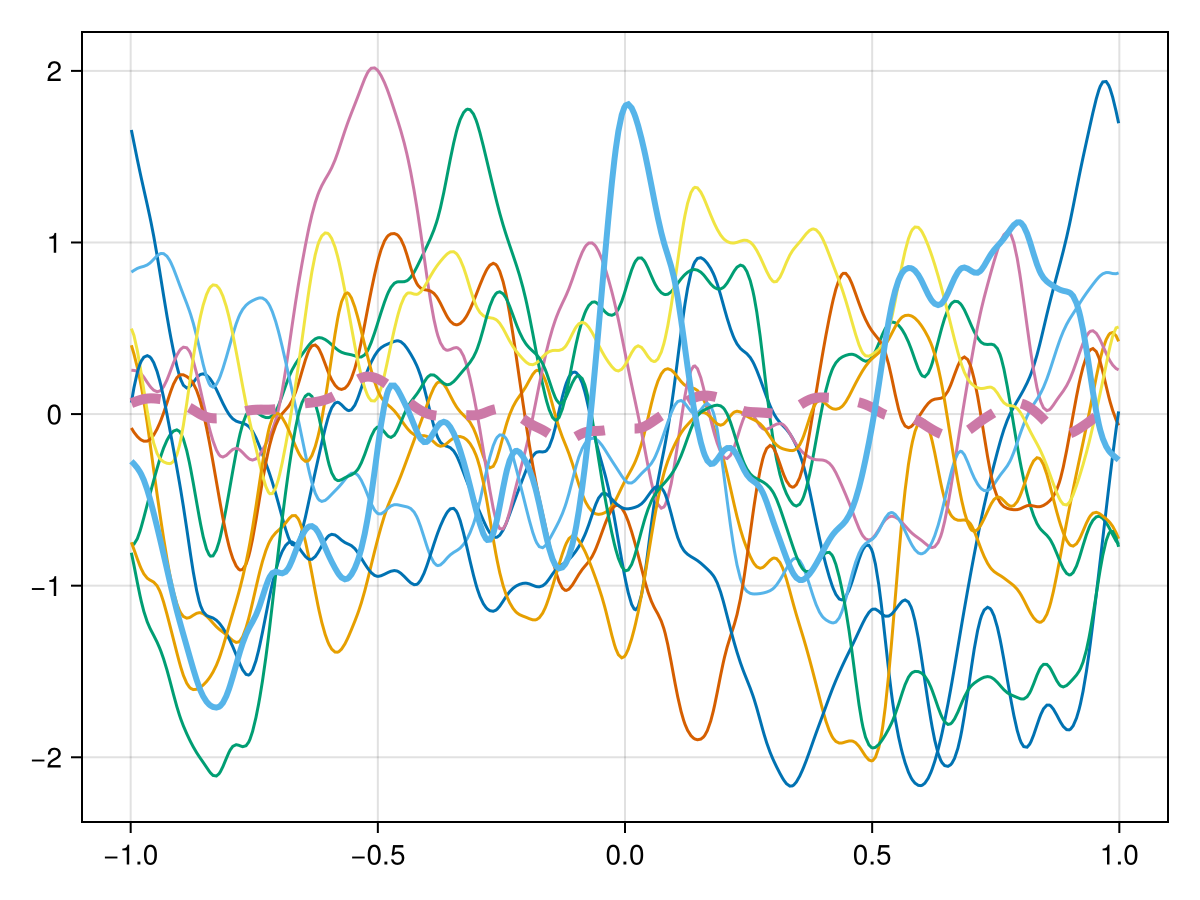

In [19]:
fig = Figure()

ax = Axis(fig[1,1])

for i=1:10
    lines!(ax, xgrid, X0[Ny+1:Ny+Nx,i])
end
lines!(xgrid, mean(X0[Ny+1:Ny+Nx,:]; dims = 2)[:,1], linewidth = 5, linestyle = :dash)

lines!(ax, xgrid, x0, linewidth = 3)

fig

In [25]:
idx = 4

## Selecion of hyper-prior parameters
# power parameter
r_range = [ 1.0, .5, -.5, -1.0 ]; 
r = r_range[idx] # select parameter 
# shape parameter
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ]; 
β = β_range[idx] # shape parameter
# rate parameters 
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ]; 
ϑ = ϑ_range[idx]
# ϑ = 1e-5

# r = -0.5
# β = 0.5
# ϑ = 0.01
dist = GeneralizedGamma(r, β, ϑ);

Define localization parameters

In [26]:
yidx = 1:Δ:Nx
idx = vcat(collect(1:length(yidx))', collect(yidx)')

# @assert length(yidx) == Ny

# # Create Localization structure
Gxx(i,j) = periodicmetric!(i,j, Nx)
Gxy(i,j) = periodicmetric!(i,yidx[j], Nx)
Gyy(i,j) = periodicmetric!(yidx[i],yidx[j], Nx)

Lrad = 7
Loc = Localization(Lrad, Gxx, Gxy, Gxx)

Localization(7.0, Gxx, Gxy, Gxx)

In [27]:
β = 1.01
ϵxβ = MultiAddInflation(Nx, β, zeros(Nx), σx)

MultiAddInflation(400, 1.01, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

Define linear maps for ObsSystem and ObsConstraintSystem

In [28]:
Cθ = LinearMap(Diagonal(rand(dist, Ns)))
Cϵ = LinearMap(ϵy.Σ)
CX = LinearMap(Diagonal(1.0 .+ rand(Nx)))

400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}

In [29]:
sys_y = ObsSystem(H, Cϵ, CX)

ObsSystem(400, 20, 20×400 LinearMaps.WrappedMap{Float64} of
  20×400 SparseMatrixCSC{Float64, Int64} with 20 stored entries, 20×20 LinearMaps.WrappedMap{Float64} of
  20×20 Diagonal{Float64, Vector{Float64}}, LinearMap[400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}])

Define localized EnKF

In [30]:
locenkf = LocEnKF(Ne, ϵy, sys_y, Loc, Δtdyn, Δtobs)

Localized ensemble Kalman filter with filtered = false


In [31]:
X_locenkf = seqassim_trixi(data, Tf, ϵxβ, locenkf, deepcopy(X0), model.Ny, model.Nx, t0, sys_burgers);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


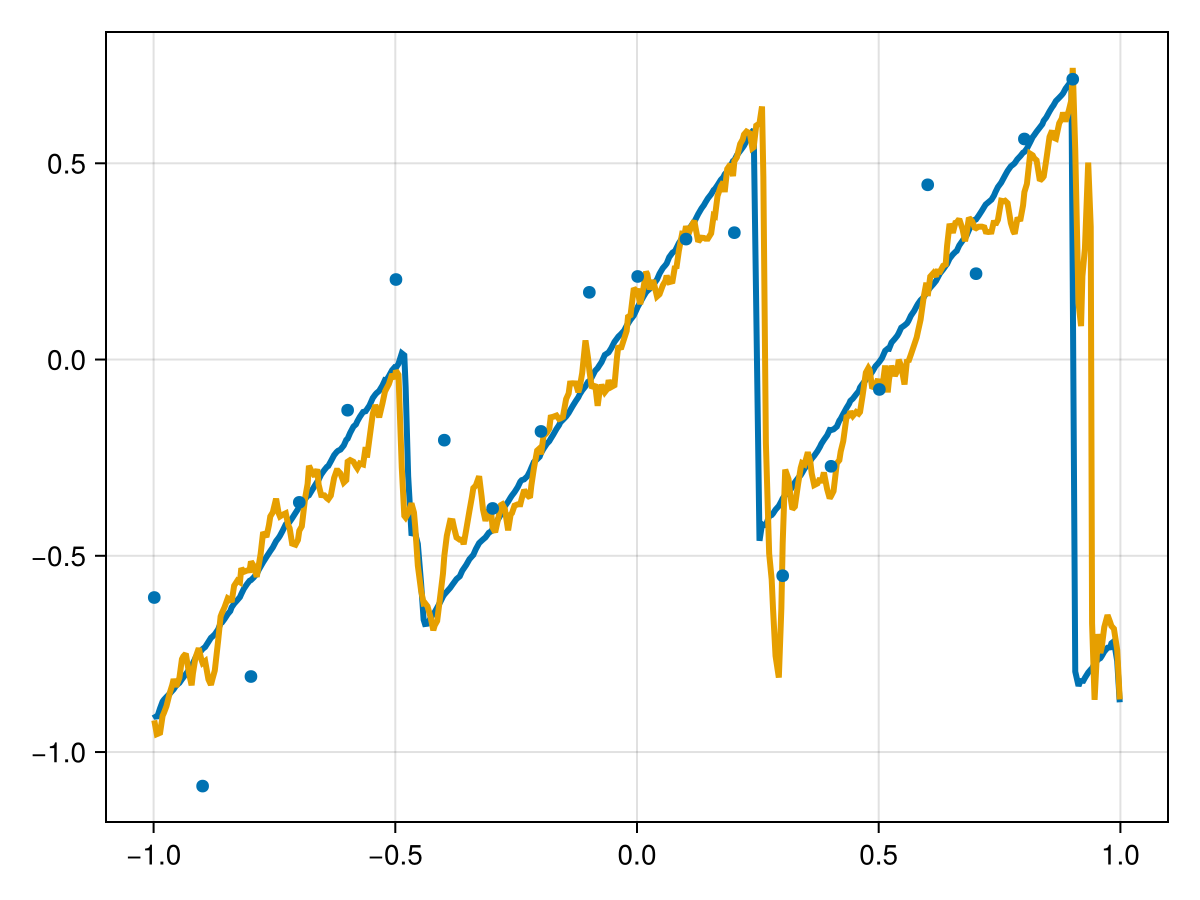

In [40]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 50
idx = 10

lines!(ax, xgrid, data.xt[:,tsnap], linewidth = 3, label = "Truth")
lines!(ax, xgrid, X_locenkf[tsnap+1][:,2], linewidth = 3, label = "LocEnKF")
scatter!(ax, xgrid[1:Δ:end], data.yt[:,tsnap])


fig

In [42]:
rmse_locenkf = mean(map(i->norm(data.xt[:,i]-mean(X_locenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.14302441122234275

Define initial jump profile

In [43]:
θinit = rand(dist, Ns);

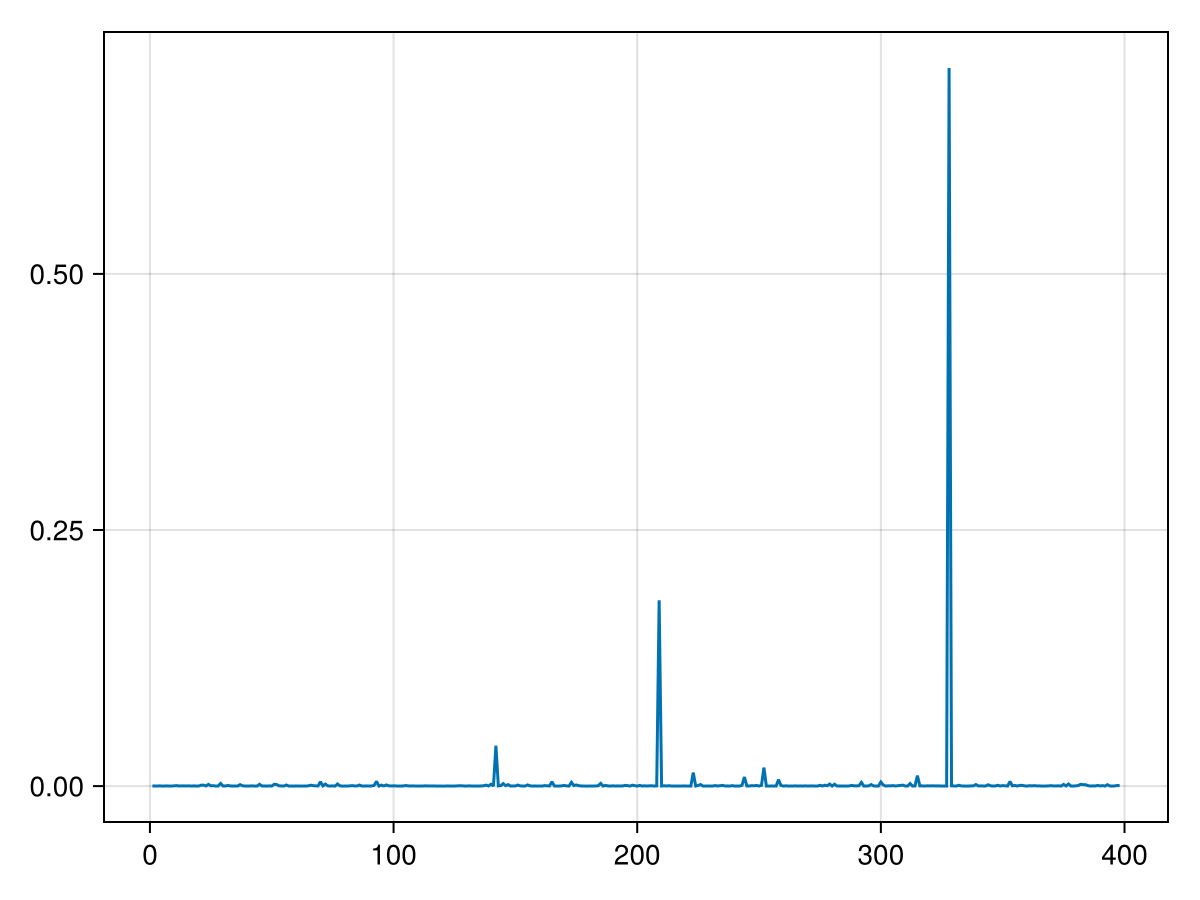

In [44]:
fig = Figure()

lines(θinit)

Define ObsConstraintSystem

In [45]:
sys_ys = ObsConstraintSystem(H, S, Cθ, Cϵ, CX)

ObsConstraintSystem(400, 20, 398, 20×400 LinearMaps.WrappedMap{Float64} of
  20×400 SparseMatrixCSC{Float64, Int64} with 20 stored entries, 398×400 LinearMaps.FunctionMap{Float64,true}(#1, #2; issymmetric=false, ishermitian=false, isposdef=false), 398×398 LinearMaps.WrappedMap{Float64} of
  398×398 Diagonal{Float64, Vector{Float64}}, 20×20 LinearMaps.WrappedMap{Float64} of
  20×20 Diagonal{Float64, Vector{Float64}}, LinearMap[400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}])

In [46]:
sys_ys.CX[1] = LinearMaps.FunctionMap{Float64,true}(
        (y, x) -> mul!(y, EmpiricalCov(X_locenkf[end]), x),
        Nx;
        issymmetric = true,
        isposdef = false,
    )

400×400 LinearMaps.FunctionMap{Float64,true}(#13; issymmetric=true, ishermitian=true, isposdef=false)

In [47]:
sys_mat = zeros(Ny + Ns, Ny + Ns)

ei = zeros(Ny + Ns)
for i = 1:Ny+Ns
    fill!(ei, 0.0)
    ei[i] = 1.0
    sys_mat[:, i] = sys_ys * ei
end

Define hierarchical EnKF

In [48]:
henkf = HEnKF(Ne, ϵy, sys_ys, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical ensemble Kalman filter with filtered = false


Define hierarchical and localized EnKF

In [49]:
hlocenkf = HLocEnKF(Ne, ϵy, sys_ys, Loc, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical localized ensemble Kalman filter with filtered = false


In [50]:
# Define linear system at one time instant

In [51]:
X = X_locenkf[end];
ystar = data.yt[:,end];

In [52]:
θ = rand(dist, Ns);

In [53]:
ĈX = LocalizedEmpiricalCov(X, hlocenkf.Loc; with_matrix = true)

ĈX_op = LinearMaps.FunctionMap{Float64,true}(
(y, x) -> mul!(y, ĈX, x),
Nx;
issymmetric = true,
isposdef = true,
)

hlocenkf.sys.CX[1] = ĈX_op

400×400 LinearMaps.FunctionMap{Float64,true}(#15; issymmetric=true, ishermitian=true, isposdef=true)

In [54]:
hlocenkf.θ .= θ
hlocenkf.sys.Cθ.lmap.diag .= θ;

In [55]:
sys_op = LinearMaps.FunctionMap{Float64,true}(
        (y, x) -> mul!(y, hlocenkf.sys, x),
        Ny + Ns;
        issymmetric = true,
        isposdef = true)

418×418 LinearMaps.FunctionMap{Float64,true}(#17; issymmetric=true, ishermitian=true, isposdef=true)

In [70]:
bi = ObsConstraintVector(Ny, Ns)

idx = 1
xi = view(X, :, idx)
yi = observation(bi)
si = constraint(bi)

mul!(yi, hlocenkf.sys.H, xi)
yi .+= - ystar

mul!(si, hlocenkf.sys.S, xi);

In [71]:
Preconditioners.CholeskyPreconditioner

CholeskyPreconditioner

In [78]:
@time δi = cg(sys_op, bi; log = true, abstol = 1e-3)

  0.005598 seconds (2.64 k allocations: 2.374 MiB)


(ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}(([-11.015772761331391, 6.931508757550433, 4.428669273902134, -1.2061195718886413, -1.2533754259868297, 5.038403676426109, -0.6291842215106929, 5.30932044905244, -15.849873387033078, -4.341451965916157, -3.325556051298261, 2.9098264961527183, -1.4063481869862995, 10.054604479462641, 4.90514224375083, 2.722756758331546, -4.185460275744165, 7.464458969162555, -5.0993477651493695, -2.5714724567413874], [-6.888422916032397, -4.456658657986955, -0.36716003801459496, -11.598739148818455, -0.8881396249534047, 2.574816956250115, -9.252615539188225, -17.492436458574094, 6.882050263695165, 29.19395682264019  …  -36.63834311169217, 18.728543154710795, 14.072214568009398, -18.095244574084823, -18.79623771703457, 40.37316674919396, -38.26229880663611, 8.993634472667761, -21.219876940607328, -24.04294927170731])), Converged after 64 iterations.)

In [79]:
@time δi = cg(sys_op, bi; log = true, Pl = Preconditioners.CholeskyPreconditioner(sys_mat), abstol = 1e-3)

  0.133721 seconds (8.80 k allocations: 16.261 MiB)


(ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}(([-11.01837751047609, 6.933188062962545, 4.426686088637775, -1.2051514225253508, -1.252116949872815, 5.035782851165685, -0.6254765622752063, 5.313301985091968, -15.849410674967558, -4.344814209444498, -3.3270216059515807, 2.9084562436664174, -1.4102483153732857, 10.05196737196695, 4.903572872909091, 2.724301878083103, -4.186476556232603, 7.470256012136055, -5.098868911737489, -2.566243269502729], [-6.852731567830292, -4.463149384037118, -0.3760240446162419, -11.625883661787096, -0.9079411068089834, 2.5378678135228805, -9.276792587193137, -17.531687728627713, 6.855669012772573, 29.19576489630657  …  -36.687146534908244, 18.67919415102231, 13.984844953632656, -18.298997191385364, -18.871365392205472, 40.322649258671966, -38.301767362235914, 8.958140049752119, -21.236512136064917, -23.99639389405169])), Converged after 204 iterations.)

In [144]:
δwarm = deepcopy(δi[1]);

In [147]:
@time cg!(δwarm, sys_op, bi; log = true, abstol = 1e-3)

  0.000078 seconds (55 allocations: 52.281 KiB)


(ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}(([3.0820185634219737, -4.6068723848334425, -1.4309668599772785, 5.715869034502246, -0.8442398395287131, 2.5200301039058357, 3.5863649278541305, 0.8903196414524597, 5.998495012270931, 0.3547508134012248, -2.7279610072733393, -0.5708392499739371, 0.11977747449527006, -8.408169772460138, -5.3393146916081164, 0.3882831344585372, -0.006233278227714731, -9.372725652968763, 2.6617865217942387, 5.114965181761601], [-30.141122010230625, -5.57662726848805, 7.71111993377314, -43.061844290307896, -0.31497398590646014, -22.14185266254528, -8.295539523091112, 6.510807332264642, 1.652376843396585, 0.2674198286593197  …  -7.368730892283487, -7.076823389559498, 7.588354030690573, -15.068191845259149, -2.33794496361976, 1.810844797579435, 16.9546153689612, 85.83110774287735, 13.152963469645334, 37.251038433960304])), Converged after 0 iterations.)

In [82]:
function f_ei(i, N)
    out = zeros(N)
    out[i] = 1.0
    return out
end

f_ei (generic function with 1 method)

In [83]:
sys_mat = zeros(Ny + Ns, Ny + Ns)

ei = zeros(Ny + Ns)
for i = 1:Ny+Ns
    fill!(ei, 0.0)
    ei[i] = 1.0
    sys_mat[:, i] = sys_op * ei
end

# sys_mat = factorize(Symmetric(sys_mat))
sys_mat

418×418 Matrix{Float64}:
  0.0425825    0.0        0.0        0.0        …  -0.000483502   0.000183073
  0.0          0.0420176  0.0        0.0            0.0           0.0
  0.0          0.0        0.0412626  0.0            0.0           0.0
  0.0          0.0        0.0        0.0418472      0.0           0.0
  0.0          0.0        0.0        0.0            0.0           0.0
  0.0          0.0        0.0        0.0        …   0.0           0.0
  0.0          0.0        0.0        0.0            0.0           0.0
  0.0          0.0        0.0        0.0            0.0           0.0
  0.0          0.0        0.0        0.0            0.0           0.0
  0.0          0.0        0.0        0.0            0.0           0.0
  0.0          0.0        0.0        0.0        …   0.0           0.0
  0.0          0.0        0.0        0.0            0.0           0.0
  0.0          0.0        0.0        0.0            0.0           0.0
  ⋮                                             ⋱        

In [84]:
cond(sys_mat)

15130.949448447058

In [36]:
tsnap = Observable(1)

x_tsnap = @lift(data.xt[:,$tsnap])
y_tsnap = @lift(data.yt[:,$tsnap])
X_locenkf_tsnap = @lift(mean(X_locenkf[$tsnap+1]; dims = 2)[:,1])



fig = Figure()

ax1 = Axis(fig[1,1])

lines!(ax1, xgrid, x_tsnap, linewidth = 3, label = "Truth")
lines!(ax1, xgrid, X_locenkf_tsnap, linewidth = 3, label = "LocEnKF")
scatter!(ax1, xgrid[1:Δ:end], y_tsnap)

axislegend(ax1)


framerate = 10
timestamps = range(1, 100, step = 1)

record(fig, "enkf_inviscid_burgers.mp4", timestamps; framerate = framerate) do t
    tsnap[] = t
end

"enkf_inviscid_burgers.mp4"